# PLOT THE EXPERIMENTS

Import necessary libraries

In [1]:
import numpy as np
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import re


Define the utility function <br />  
The parameter of the utility function is the weighted average of the means

In [2]:
def Mixtures(tauO, p_arms):
    p_out = 0
    for i in range(len(tauO)):
        p_out += tauO[i]*p_arms[i]
    return p_out

def Utility(p):
    return p*(1-p)

def Regret(tauT, pb):
    return 1/4-Utility(Mixtures(tauT, pb))

In [3]:
def parse_complex_string(data_string):
    # Extended regex pattern to include parentheses in the key and match list or numeric values
    pattern = r'(\w+\(?\w*\)?)=([\[\]0-9., ]+)'
    results = re.findall(pattern, data_string)
    
    # Dictionary to hold the parsed data
    parsed_data = {}
    
    for key, value in results:
        # Attempt to evaluate lists and convert numerical strings to floats or ints
        try:
            # Remove spaces and evaluate as list if value starts with '['
            if value.strip().startswith('['):
                # Handling list of floats or ints
                cleaned_list = eval(value.strip())
                parsed_data[key] = cleaned_list
            else:
                # Convert simple numeric values to float or int
                parsed_data[key] = float(value) if '.' in value else int(value)
        except:
            # Leave the value as is if not a list or float (or in case of any error)
            parsed_data[key.strip()] = value
    
    return parsed_data

In [4]:
def pbfunc(params):
    pb = []
    pb_string_list = params["pb"][0]
    for stri in pb_string_list:
        pb.append(float(stri))
    return pb

In [5]:
def taufunc(params):
    tauT = []
    tauT_string_list = params["tau(T)"].replace("[", "").replace("]", "").strip().split(".")[:-1]
    for stri in tauT_string_list:
        tauT.append(int(stri))
    return tauT

In [6]:
from collections import defaultdict
import re

def parameter_based_analysis(filename, group_by='T'):
    # Define a dictionary to store values grouped by the specified parameter
    results = defaultdict(list)
    params = defaultdict(list)
    averages = defaultdict(list)

    # Open the file and parse lines
    with open(filename, "r") as file:
        for line in file:
            params = parse_complex_string(line)


            # Determine the grouping parameter and extract the relevant value
            T = int(params['T'].replace(",",""))
            if group_by == 'p1-p2' and 'p1' in params and 'p2' in params:
                
                p1 = float(params['p1'].replace(",",""))
                p2 = float(params['p2'].replace(",",""))
                pb = [p1, p2]
                
                key_value = tuple(pb)
            
            elif group_by == 'p1-p2' and 'pb' in params:
                    pb = pbfunc(params)
                    key_value = tuple(pb)
                    
                
            elif group_by == 'T':
                key_value = float(params[group_by].replace(",",""))
                if 'p1' in params and 'p2' in params:
                    p1 = float(params['p1'].replace(",",""))
                    p2 = float(params['p2'].replace(",",""))
                    pb = [p1, p2]
                    
                elif 'pb' in params:
                    pb = pbfunc(params)
                    
            elif group_by=='K':
                key_value = float(params[group_by].replace(",",""))
                pb = pbfunc(params)
                
            elif group_by=='zeta':
                key_value = float(params[group_by].replace(",",""))
                pb = pbfunc(params)
                

            else:
                continue  # Skip the line if it does not contain necessary parameters

            # Extract tau(T) value assuming you're interested in the first value
            tau_values = taufunc(params)
            results[key_value].append(tau_values)
    
    
    # Calculate regret for each key
    regret_dict = {}
    all_variances = {}
    if group_by == 'T':
        for t, result_list in results.items():
            temp_regret = 0
            t_regret_list = []
            for taus in result_list:
                TauT = np.array(taus) / t  
                temp_regret += Regret(TauT, pb)
                t_regret_list.append(Regret(TauT, pb))
                
            t_regret = temp_regret/len(result_list)

            regret_dict[t] = t_regret

            print(f"{group_by}={t}: Regret = {t_regret}")
            
            all_variances[t] = np.sum(np.square(np.array(t_regret_list)-t_regret))/(len(t_regret_list))
 
    
    elif group_by == 'p1-p2':
        for pb, result_list in results.items():
            temp_regret = 0
            pb_regret_list = []
            for taus in result_list:
                TauT = np.array(taus) / T  
                temp_regret += Regret(TauT, pb)
                pb_regret_list.append(Regret(TauT, pb))
            
            pb_regret = temp_regret/len(result_list)
            
            regret_dict[pb[0]-pb[1]] = pb_regret
 
            print(f"{group_by}={round(pb[0]-pb[1], 2)}: Regret = {pb_regret}")
            
            all_variances[pb[0]-pb[1]] = np.sum(np.square(np.array(pb_regret_list)-pb_regret))/(len(pb_regret_list))
    
    
    
    elif group_by == 'K':
        for K, result_list in results.items():
            temp_regret = 0
            K_regret_list = []
            for taus in result_list:
                TauT = np.array(taus) / T  
                temp_regret += Regret(TauT, pb)
                K_regret_list.append(Regret(TauT, pb))
                
            k_regret = temp_regret/len(result_list)

            regret_dict[K] = k_regret
 
            print(f"{group_by}={K}: Regret = {k_regret}")
            
            all_variances[K] = np.sum(np.square(np.array(K_regret_list)-k_regret))/(len(K_regret_list))
    
    elif group_by == 'zeta':
        for zeta, result_list in results.items():
            temp_regret = 0
            z_regret_list = []
            for taus in result_list:
                TauT = np.array(taus) / T  
                temp_regret += Regret(TauT, pb)
                z_regret_list.append(Regret(TauT, pb))
                
            z_regret = temp_regret/len(result_list)

            regret_dict[zeta] = z_regret
 
            print(f"{group_by}={zeta}: Regret = {z_regret}")
    
            all_variances[zeta] = np.sum(np.square(np.array(z_regret_list)-z_regret))/(len(z_regret_list))
        
    return regret_dict, all_variances

# Example usage:
regret_dict_T, variance_dict_T = parameter_based_analysis('Results_T_SEC_CONFIR_LONG.txt', 'T')
#regret_dict_RANDOM, variance_dict_RANDOM = parameter_based_analysis('Results_RANDOM_SAMPLING_LONGEST.txt', 'T')
#regret_dict_UUCB, variance_dict_UUCB = parameter_based_analysis('Results_RANDOM_SAMPLING.txt', 'T')
regret_dict_PURE, variance_dict_PURE = parameter_based_analysis('Results_PURE_T_SEC_CONFIR.txt', 'T')

regret_dict_ETC, variance_dict_ETC = parameter_based_analysis('Results_ETC_T_SEC_CONFIR_LONG.txt', 'T')
'''
regret_dict_T, variance_dict_T = parameter_based_analysis('Results_T.txt', 'T')
regret_dict_UUCB, variance_dict_UUCB = parameter_based_analysis('Regrets_UUCB_T.txt', 'T')
regret_dict_PURE, variance_dict_PURE = parameter_based_analysis('Regrets_UNI_T.txt', 'T')
regret_dict_ETC, variance_dict_ETC = parameter_based_analysis('Regrets_ETC_T.txt', 'T')
'''

regret_dict_K, variance_dict_K = parameter_based_analysis('Results_K_LONG_3_1000.txt', 'K')
regret_dict_K_ETC, variance_dict_K_ETC = parameter_based_analysis('Results_ETC_K_3_1000.txt', 'K')

'''
regret_dict_p_diff, variance_dict_p_diff = parameter_based_analysis('Regrets_eta.txt', 'p1-p2')
regret_dict_p_diff_2, variance_dict_p_diff_2 = parameter_based_analysis('Regrets_eta_2.txt', 'p1-p2')

'''
regret_dict_zeta, variance_dict_zeta = parameter_based_analysis('Results_zeta.txt', 'zeta')


T=100000.0: Regret = 0.0004897275113000036
T=200000.0: Regret = 0.00027722133458750085
T=300000.0: Regret = 0.00019693040110277816
T=400000.0: Regret = 0.0001510223608953132
T=500000.0: Regret = 0.00012843591310599995
T=100000.0: Regret = 0.022500000000000537
T=200000.0: Regret = 0.022500000000000537
T=300000.0: Regret = 0.022500000000000537
T=400000.0: Regret = 0.022500000000000537
T=500000.0: Regret = 0.022500000000000537
T=100000.0: Regret = 0.0006249999999999977
T=200000.0: Regret = 0.0006249999999999977
T=300000.0: Regret = 0.0006249999999999977
T=400000.0: Regret = 0.0006249999999999977
T=500000.0: Regret = 0.0006249999999999977
K=2.0: Regret = 5.505517796399853e-05
K=3.0: Regret = 0.00018407446872625136
K=4.0: Regret = 0.000673724095905
K=5.0: Regret = 0.0005608097161032492
K=6.0: Regret = 0.0006809017550972492
K=2.0: Regret = 1.8292486684998722e-06
K=3.0: Regret = 0.0006537327927457458
K=4.0: Regret = 0.003906372238144
K=5.0: Regret = 0.003647468484159977
K=6.0: Regret = 0.0054

In [7]:
def UpperBound(inp="UCB", K=2, T=10000, zeta=0.05, L=1, r=2):
    if inp == "UCB":
        param1 = 8*(1/T)*(L**(1+r))*(1/((zeta)**(r/2)))*K*(T**(1-r/2))*np.log(T)**(r/2)
    
    elif inp ==  "ETC": 
        pass
        
    return param1
    

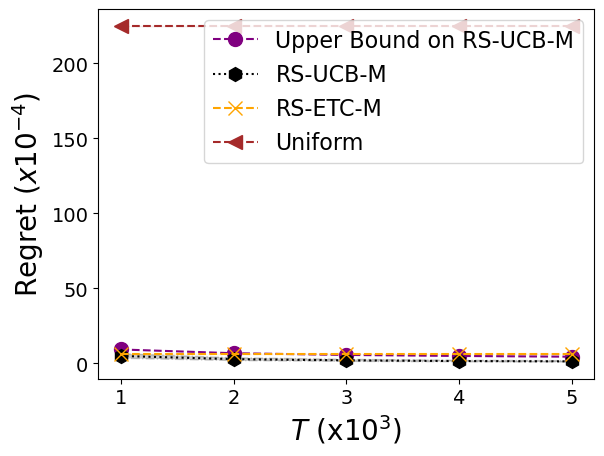

In [8]:
# Prepare for plotting
keys = list(regret_dict_T.keys())
values = list(regret_dict_T.values())
function_outputs = [UpperBound(T=key, zeta=0.1, r=1) for key in keys]

markersize=10
# Plotting
fig, ax = plt.subplots()

# Plot function outputs
ax.plot(np.array(list(keys))/1e5, 1.7e1*np.array(function_outputs), '--o', label='Upper Bound on RS-UCB-M', color='purple', markersize=markersize)

# Plot dictionary values
ax.plot(np.array(list(keys))/1e5, 1e4*np.array(list(values)), label='RS-UCB-M', linestyle=':', marker='h', color='black', markersize=markersize)


std_dev = np.sqrt(np.array(list(variance_dict_T.values())))
ax.fill_between(np.array(list(keys))/1e5, 
                 1e4*(np.array(list(values)) - std_dev), 
                 1e4*(np.array(list(values)) + std_dev), 
                 linestyle='-.', color='black', alpha=0.2)



ax.plot(np.array(list(regret_dict_ETC.keys()))/1e5, 1e4*np.array(list(regret_dict_ETC.values())), 
        linestyle='--', marker='x', label='RS-ETC-M', color="orange" , markersize=markersize)

std_dev_ETC = np.sqrt(np.array(list(variance_dict_ETC.values())))
ax.fill_between(np.array(list(regret_dict_ETC.keys()))/1e5, 
                 1e4*(np.array(list(regret_dict_ETC.values())) - std_dev_ETC), 
                 1e4*(np.array(list(regret_dict_ETC.values())) + std_dev_ETC), 
                 linestyle='--', color='orange', alpha=0.1)


ax.plot(np.array(list(regret_dict_PURE.keys()))/1e5, 1e4*np.array(list(regret_dict_PURE.values()))
        , linestyle='--', marker='<', 
        color='brown'
        , label='Uniform' , markersize=markersize)
std_dev_PURE = np.sqrt(np.array(list(variance_dict_PURE.values())))
ax.fill_between(np.array(list(regret_dict_PURE.keys()))/1e5, 
                 1e4*(np.array(list(regret_dict_PURE.values())) - std_dev_PURE), 
                 1e4*(np.array(list(regret_dict_PURE.values())) + std_dev_PURE), 
                 linestyle='-.', color='brown', alpha=0.1)


# Add labels and legend
ax.set_xlabel('$T$ (x$10^3$)', fontsize=20)
ax.set_ylabel('Regret $(x10^{-4})$', fontsize=20)
ax.legend(fontsize=16, loc='upper right')

plt.tick_params(axis='x', labelsize=14)  # Change the x-axis font size
plt.tick_params(axis='y', labelsize=14)  # Change the y-axis font size
#plt.yscale("symlog", linthresh=0.0007)

plt.savefig("AISTATS_UCB_ETC_ALL.pdf", bbox_inches='tight', pad_inches=0.1)

# Show plot
plt.show()

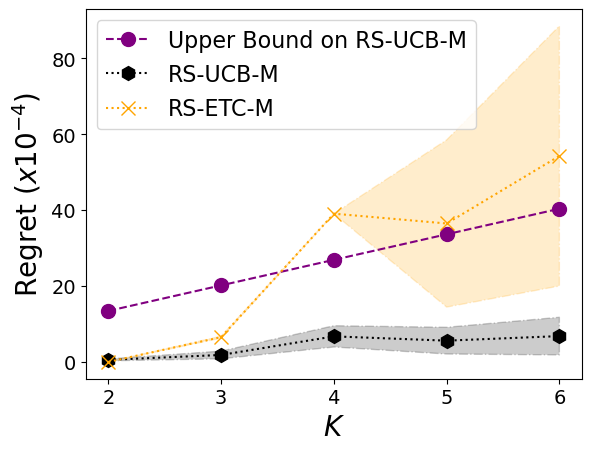

In [20]:
# Prepare for plotting
keys = list(regret_dict_K.keys())
values = list(regret_dict_K.values())
function_outputs = [UpperBound(K=int(key), zeta=0.05, T=300000) for key in keys]
plt.rcParams.update({'font.size': 11})
# Plotting
fig, ax = plt.subplots()

markersize=10

T = 300000
lower_values = np.repeat(1e3*5/T, len(values))

# Plot function outputs
ax.plot(keys, 1e3*np.array(function_outputs), '--o', label='Upper Bound on RS-UCB-M', color= 'purple', markersize=markersize)

#ax.plot(keys, lower_values,  linestyle=':', marker='p', color='red', label='Upper Bound on RS-UCB-M', markersize=markersize)

# Plot dictionary values
ax.plot(keys, 1e4*(np.array(list(values))), label='RS-UCB-M', linestyle=':', marker='h', color='black', markersize=markersize)
std_dev = np.sqrt(np.array(list(variance_dict_K.values())))
ax.fill_between(keys, 
                 1e4*(np.array(list(values)) - std_dev/2), 
                 1e4*(np.array(list(values)) + std_dev/2), 
                 linestyle='-.', color='black', alpha=0.2)

# Plot dictionary values
ax.plot(regret_dict_K_ETC.keys(), 1e4*(np.array(list(regret_dict_K_ETC.values()))), 
                                       label='RS-ETC-M', linestyle=':', marker='x', color='orange', markersize=markersize)
std_dev = np.sqrt(np.array(list(variance_dict_K_ETC.values())))
ax.fill_between(keys, 
                 1e4*(np.array(list(regret_dict_K_ETC.values())) - std_dev/2), 
                 1e4*(np.array(list(regret_dict_K_ETC.values())) + std_dev/2), 
                 linestyle='-.', color='orange', alpha=0.2)

# Add labels and legend

ax.set_xlabel('$K$', fontsize=20)
ax.set_ylabel('Regret $(x10^{-4})$', fontsize=20)
ax.legend(fontsize=16, loc='upper left')

plt.tick_params(axis='x', labelsize=14)  # Change the x-axis font size
plt.tick_params(axis='y', labelsize=14)  # Change the y-axis font size

plt.savefig("AISTATS_UCB_ETC_K.pdf", bbox_inches='tight', pad_inches=0.1)
# Show plot
plt.show()

In [ ]:
# Prepare for plotting
keys1 = list(regret_dict_p_diff.keys())
values1 = list(regret_dict_p_diff.values())

keys2 = list(regret_dict_p_diff_2.keys())
values2 = list(regret_dict_p_diff_2.values())

# Plotting
fig, ax = plt.subplots()

markersize=10
# Plot dictionary values
ax.plot(keys1, 1e4*np.array(list(values1)), label='p1=0.55', linestyle=':', marker='p', color='orange', markersize=markersize)
std_dev = np.sqrt(np.array(list(variance_dict_p_diff.values())))
ax.fill_between(keys1, 
                 1e4*(np.array(list(values1)) - std_dev/2), 
                 1e4*(np.array(list(values1)) + std_dev/2), 
                 linestyle='-.', color='orange', alpha=0.2)

# Plot dictionary values
ax.plot(keys2, 1e4*np.array(list(values2)), label='p1=0.59', linestyle=':', marker='h', color='blue', markersize=markersize)
std_dev2 = np.sqrt(np.array(list(variance_dict_p_diff_2.values())))
ax.fill_between(keys2, 
                 1e4*(np.array(list(values2)) - std_dev2/2), 
                 1e4*(np.array(list(values2)) + std_dev2/2), 
                 linestyle='-.', color='blue', alpha=0.2)

# Add labels and legend
ax.set_xlabel('$p_1-p_2$', fontsize=20)
ax.set_ylabel('Regret $(x10^{-4})$', fontsize=20)
ax.legend(fontsize=16, loc='upper left')

plt.tick_params(axis='x', labelsize=14)  # Change the x-axis font size
plt.tick_params(axis='y', labelsize=14)  # Change the y-axis font size

plt.savefig("UCB_eta.pdf", bbox_inches='tight', pad_inches=0.1)
# Show plot
plt.show()

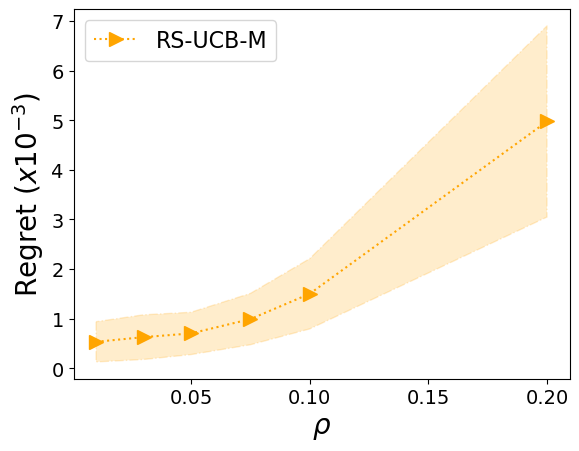

In [21]:
# Prepare for plotting
keysz = list(regret_dict_zeta.keys())
valuesz = list(regret_dict_zeta.values())

  
# Plotting
fig, ax = plt.subplots()

markersize=10

# Plot dictionary values
ax.plot(keysz, 1e3*np.array(list(valuesz)), label='RS-UCB-M', linestyle=':', marker='>', color='orange', markersize=markersize)
std_dev = np.sqrt(np.array(list(variance_dict_zeta.values())))
ax.fill_between(keysz, 
                 1e3*(np.array(list(valuesz)) - std_dev/2), 
                 1e3*(np.array(list(valuesz)) + std_dev/2), 
                 linestyle='-.', color='orange', alpha=0.2)

# Add labels and legend
ax.set_xlabel(r"$\rho$", fontsize=20)
ax.set_ylabel('Regret $(x10^{-3})$', fontsize=20)
ax.legend(fontsize=16, loc='upper left')

plt.tick_params(axis='x', labelsize=14)  # Change the x-axis font size
plt.tick_params(axis='y', labelsize=14)  # Change the y-axis font size

plt.savefig("AISTATS_UCB_Zeta.pdf", bbox_inches='tight', pad_inches=0.1)
# Show plot
plt.show()